In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Normal Distribution
It's a univariate probability distribution for continous real random variable.  
mean $\mu$ and standard deviation $\sigma$ are the distribution paramters. 
Probability density function is given by,  

$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp{-\frac{1}{2}\left[\frac{x - \mu}{\sigma}\right]^2}$$

In [2]:
class Normal(object):
    def __init__(self, mean = None, var = None):
        """
        mean and varience which are parameters of Normal Distribution, 
        are the attributes for this class. If specified while initialisation 
        class is initialised with those values otherwise with None
        """
        self.mean = mean
        self.var  = var
        
    def pdf(self, x):
        """
        Function takes real number x as input and returns probability density 
        value curresponding to it.
        if distribution parameters are not defiend it will raise an error
        """
        if self.mean is None or self.var is None:
            raise Exception('Distribution Parameters are not set')
        
        sigma = np.sqrt(self.var)
        mu  = self.mean
        f = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-1/2 * ((x - mu) / sigma)**2)
        return f
    
    def logLH(self, x):
        """
        Function takes real number x as input and returns log of probability 
        density value curresponding to it.
        if distribution parameters are not defiend it will raise an error
        """
        if self.mean is None or self.var is None:
            raise Exception('Distribution Parameters are not set')
        
        return np.log10(self.pdf(x))
    
    def fit(self, X):
        """
        Function takes array of realisations of random variable and 
        sets values of distribution parameters by their estimates 
        based on data
        """
        self.mean = np.mean(X)
        self.var  = np.var(X)
    
    def plot(self):
        """
        Function Plots the density function
        if distribution parameters are not defiend it will raise an error
        """      
        if self.mean is None or self.var is None:
            raise Exception('Distribution Parameters are not set')
        sigma = np.sqrt(self.var)
        mu  = self.mean
        x = np.linspace( (mu - 3*sigma) , (mu + 3*sigma), 100)
        y = self.pdf(x)
        plt.plot(x,y)
        plt.show()
        
    def __str__(self):
        if self.mean is None or self.var is None:
            return 'Distribution Parameters are not set'
        else:
            return "Normal distribution with mean " + str('{:.2e}'.format(self.mean)) + " and varience " + str('{:.2e}'.format(self.var))

### Understanding the class

In [3]:
# Initialising class with parameters
dist = Normal(mean = 0, var = 1)
print(dist)

Normal distribution with mean 0.00e+00 and varience 1.00e+00


In [4]:
# Probability density value 
x = 0.5
fx = dist.pdf(x)
print('Probability density value at ', x,' is ', fx)

Probability density value at  0.5  is  0.3520653267642995


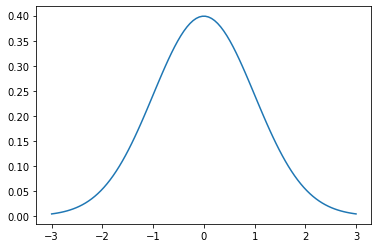

In [5]:
dist.plot()

In [6]:
# Initialising class without parameters
distribution = Normal()
print(distribution)

Distribution Parameters are not set


In [7]:
# Fitting Probability density function paramters from data 
X = np.random.normal(0, 1, 1000)
distribution.fit(X)
print(distribution)

Normal distribution with mean -1.94e-02 and varience 9.94e-01


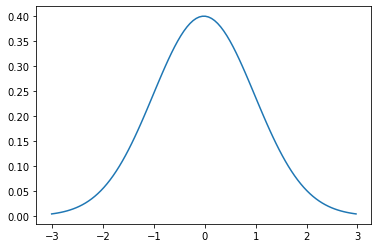

In [8]:
distribution.plot()

## Naive Bayes
Baye's theorem for even A and B is given by,  
$$ P(B|A) = \frac{P(A|B)P(B)}{P(A)} $$  

For classification problem we want label $y$ based on values of set of attributes $X = \{x_1, x_2,..., x_n\}$. above formula can be written as,  
$$ P(y|\{x_1, x_2,..., x_n\}) = \frac{P(\{x_1, x_2,..., x_n\}|y)P(y)}{P(\{x_1, x_2,..., x_n\})} $$   

Assuming atributes are independant, 
$$ P(y|\{x_1, x_2,..., x_n\}) = \frac{P(x_1|y).P(x_2|y)...P(x_n|y)P(y)}{P(\{x_1, x_2,..., x_n\})} $$  

Probability of y taking specific value $y_1$ for given set of attributes $X = \{x_1, x_2,..., x_n\}$ is given by,  

$$ P(y=y_1|\{x_1, x_2,..., x_n\}) = \frac{P(y=y_1)P(x_1|y=y_1).P(x_2|y=y_1)...P(x_n|y=y_1)}{P(\{x_1, x_2,..., x_n\})} $$ 

Similarly, Probability for each possible value of y can be computed and compared to make prediction.  
As denominator is independant of value of y, it can be ignored. we get following equation. 

$$ P(y=y_1|\{x_1, x_2,..., x_n\}) \propto P(y=y_1) \prod_{i = 1}^{n}{P(x_i|y=y_1)} $$ 

Prediction can be written as,

$$ \hat{y} = argmax_y \left[P(y=y_1) \prod_{i = 1}^{n}{P(x_i|y=y_1)}\right] $$

In [9]:
class NaiveBayes(object):
    def __init__(self):
        """
        self.categories - list of output categories / labels
        self.attributes - list of attributes
        self.condP - conditional probability dataframe, which contains the distributions 
                     for each attribute given each category
        self.catgP - dictionary of probability of each category / label
        """
        self.categories = None
        self.attributes = None
        self.condP = None
        self.catgP = None

    def fit(self, X, Y, dist):
        """
        Input:
        X - Pandas dataframe where each column gives different attribute values
        Y - Pandas series with labels curresponding to X
        dist - distribution class
        
        With given inputes this function fills the attributes of the NaiveBayes class
        """

        self.categories = list(np.unique(Y))
        self.attributes = list(X.columns)
        
        att, cat = len(self.attributes), len(self.categories)
        
        condP = pd.DataFrame(np.zeros((att, cat)), columns = self.categories, index = self.attributes)
        for attribute in self.attributes:
            for categorie in self.categories:
                condP.loc[attribute,categorie] = dist()
                condP.loc[attribute,categorie].fit(X.loc[Y == categorie, attribute])
        self.condP = condP
        
        catgP = {}
        for categorie in self.categories:
            catgP[categorie] = sum(Y == categorie)/len(Y)
        self.catgP = catgP
    
    def model(self, X):
        """
        Input:
        X - pandas series with set of attributes
        Output:
        function returns predicted label based on given set of attributes
        """
        predProb = {}
        for categorie in self.categories:
            predProb[categorie] = 0
            for attribute in self.attributes:
                predProb[categorie] = predProb[categorie] + self.condP.loc[attribute,categorie].logLH(X[attribute]) + np.log10(self.catgP[categorie])
        return max(predProb, key = predProb.get)
    
    def predict(self, X):
        row, col = X.shape
        pred = []
        for each in range(row):
            pred.append(self.model(X.iloc[each,]))
        return pred

In [10]:
df = pd.read_csv('iris.csv')
df = df.sample(frac = 1) 

In [11]:
row, col = df.shape
frac  = row//5
train = df.iloc[frac:,]
test  = df.iloc[:frac,]

In [12]:
X_train = train.iloc[:,range(col-1)]
Y_train = train.iloc[:,col-1]
X_test  = test.iloc[:,range(col-1)]
Y_test  = test.iloc[:,col-1]

In [13]:
# Creating an instance of the NaiveBayes class
NB = NaiveBayes()

# Generating model based on data with Normal distribution assumption
NB.fit(X_train,Y_train,Normal)

In [14]:
# Prediction using NaiveBayes
Y_pred = NB.predict(X_test)

# Calculating accuracy
Accuracy = sum(Y_pred == Y_test)/len(Y_test)
print('Accuracy of prediction is ', round(Accuracy*100,2),'%' )

Accuracy of prediction is  96.67 %
